In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv('/Users/justinlum/Downloads/NUS/AY2425S1/BT4012/Project file/Fraudulent_E-Commerce_Transaction_Data.csv')

**Data Overview**

In [3]:
data.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction Amount,1472952.0,226.768309,270.395099,10.0,68.61,151.76,296.05,12701.75
Quantity,1472952.0,3.000230,1.414736,1.0,2.00,3.00,4.00,5.00
Customer Age,1472952.0,34.512081,10.003134,-16.0,28.00,35.00,41.00,86.00
Is Fraudulent,1472952.0,0.050129,0.218212,0.0,0.00,0.00,0.00,1.00
Account Age Days,1472952.0,179.646398,106.864223,1.0,86.00,179.00,272.00,365.00
Transaction Hour,1472952.0,11.286964,6.975995,0.0,5.00,11.00,17.00,23.00


In [6]:
# Define the target column and features
X = data.drop(columns=['Is Fraudulent'])  # Replace with your actual target column name
y = data['Is Fraudulent']

# Split into train (70%) and temp (30% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp into validation (15% of total) and test (15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Combine features and target into single DataFrames
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check split sizes
print(f"Train set: {train.shape}")
print(f"Validation set: {val.shape}")
print(f"Test set: {test.shape}")

Train set: (1031066, 16)
Validation set: (220943, 16)
Test set: (220943, 16)


In [7]:
train.head()


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Hour,Is Fraudulent
170703,9510fb91-53c5-48cf-8f52-503906400d31,b7cd54bd-55a5-4366-8824-39b96dc93172,148.38,2024-02-17 11:59:17,debit card,toys & games,5,53,Port Andrea,tablet,104.74.150.236,"PSC 9232, Box 8361\nAPO AP 83355","PSC 9232, Box 8361\nAPO AP 83355",282,11,0
44874,c2e16192-de80-4eef-8394-0689b5932014,d7c6f09e-2949-454e-9dea-1ff91d147069,120.34,2024-04-02 11:13:02,credit card,health & beauty,1,35,Kendraville,mobile,18.102.137.222,76632 Shane Branch Suite 326\nNorth Samuelvill...,76632 Shane Branch Suite 326\nNorth Samuelvill...,347,11,0
1164826,63ec72a7-b836-411b-91a6-b97244fb9863,61cab450-4def-42a0-9190-4b38dcd8b6fc,112.44,2024-02-22 06:52:35,PayPal,clothing,3,32,Davistown,mobile,46.127.34.27,"4588 Logan Wall Suite 845\nLake Nicholas, RI 4...","4588 Logan Wall Suite 845\nLake Nicholas, RI 4...",294,6,0
130228,88a1cc98-dab6-44e4-a5e6-6e636f5ae44d,cb8c0540-7f02-4d73-9a34-0456194a7e15,66.26,2024-03-31 09:49:44,debit card,electronics,4,38,New Matthewchester,tablet,131.13.112.34,"398 Mathis Overpass\nPort Davidburgh, NY 45946","398 Mathis Overpass\nPort Davidburgh, NY 45946",217,9,0
857133,4c0d32b1-d218-411b-a4e9-6e70bb17efd3,3f3b7498-a13e-44c6-8685-870974425c49,375.28,2024-03-16 18:14:23,bank transfer,home & garden,3,50,East Davidmouth,mobile,136.84.24.53,"460 Rose Cliff\nScottview, SC 89722","460 Rose Cliff\nScottview, SC 89722",167,18,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031066 entries, 170703 to 363033
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1031066 non-null  object 
 1   Customer ID         1031066 non-null  object 
 2   Transaction Amount  1031066 non-null  float64
 3   Transaction Date    1031066 non-null  object 
 4   Payment Method      1031066 non-null  object 
 5   Product Category    1031066 non-null  object 
 6   Quantity            1031066 non-null  int64  
 7   Customer Age        1031066 non-null  int64  
 8   Customer Location   1031066 non-null  object 
 9   Device Used         1031066 non-null  object 
 10  IP Address          1031066 non-null  object 
 11  Shipping Address    1031066 non-null  object 
 12  Billing Address     1031066 non-null  object 
 13  Account Age Days    1031066 non-null  int64  
 14  Transaction Hour    1031066 non-null  int64  
 15  Is Fraudulent   

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction Amount,1031066.0,226.691747,270.235106,10.0,68.5,151.63,296.2,12701.75
Quantity,1031066.0,2.999079,1.414786,1.0,2.0,3.00,4.0,5.00
Customer Age,1031066.0,34.518217,10.005049,-16.0,28.0,35.00,41.0,81.00
Account Age Days,1031066.0,179.638598,106.856956,1.0,86.0,179.00,272.0,365.00
Transaction Hour,1031066.0,11.285106,6.972781,0.0,5.0,11.00,17.0,23.00
Is Fraudulent,1031066.0,0.050130,0.218213,0.0,0.0,0.00,0.0,1.00


## **Data Cleaning and Feature Engineering**

Customer Age

In [10]:
# Clean customer age
mean_age_train = X_train['Customer Age'].mean()
train.loc[X_train['Customer Age'] < 12, 'Customer Age'] = mean_age_train

mean_age_val = X_val['Customer Age'].mean()
val.loc[X_val['Customer Age'] < 12, 'Customer Age'] = mean_age_val

mean_age_test = X_test['Customer Age'].mean()
test.loc[X_test['Customer Age'] < 12, 'Customer Age'] = mean_age_test

/var/folders/8f/059mmz814bq3z_xwhvm3qknr0000gn/T/ipykernel_2103/2835236100.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.51821706854847' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[X_train['Customer Age'] < 12, 'Customer Age'] = mean_age_train
/var/folders/8f/059mmz814bq3z_xwhvm3qknr0000gn/T/ipykernel_2103/2835236100.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.5140511353607' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val.loc[X_val['Customer Age'] < 12, 'Customer Age'] = mean_age_val
/var/folders/8f/059mmz814bq3z_xwhvm3qknr0000gn/T/ipykernel_2103/2835236100.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.48147712305889' has dtype incompatible with i

Age groups

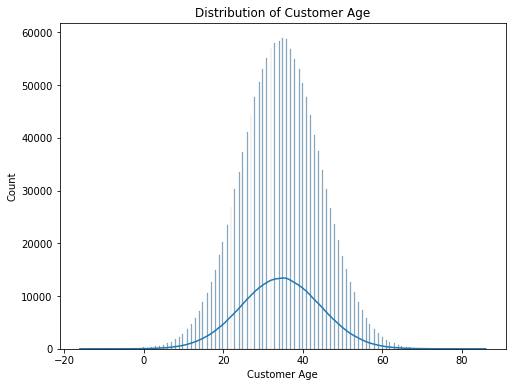

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Customer Age'], kde=True)
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.title('Distribution of Customer Age')
plt.show()

In [12]:
# Create age groups

def age_groups(x):
    if x < 20:
        return 0
    elif 20 <= x <= 29:
        return 1
    elif 30 <= x <= 39:
        return 2
    elif 40 <= x <= 49:
        return 3
    elif 50 <= x <= 59:
        return 4
    else:
        return 5
    
train['Age Group'] = X_train['Customer Age'].apply(age_groups)
val['Age Group'] = X_val['Customer Age'].apply(age_groups)
test['Age Group'] = X_test['Customer Age'].apply(age_groups)

Transaction Date

In [13]:
# Clean transaction date
train["Transaction Date"] = pd.to_datetime(train["Transaction Date"])
train['Transaction Day'] = train["Transaction Date"].dt.day.astype(int)
train["Transaction Day of Week"] = train["Transaction Date"].dt.day_of_week.astype(int)
train["Transaction Month"] = train["Transaction Date"].dt.month.astype(int)

val["Transaction Date"] = pd.to_datetime(val["Transaction Date"])
val['Transaction Day'] = val["Transaction Date"].dt.day.astype(int)
val["Transaction Day of Week"] = val["Transaction Date"].dt.day_of_week.astype(int)
val["Transaction Month"] = val["Transaction Date"].dt.month.astype(int)

test["Transaction Date"] = pd.to_datetime(test["Transaction Date"])
test['Transaction Day'] = test["Transaction Date"].dt.day.astype(int)
test["Transaction Day of Week"] = test["Transaction Date"].dt.day_of_week.astype(int)
test["Transaction Month"] = test["Transaction Date"].dt.month.astype(int)


Time of day groups

In [14]:
# Create time of day groups

def time_of_day_groups(x):
    if x < 6:
        return 0
    elif 6 <= x <= 11:
        return 1
    elif 12 <= x <= 17:
        return 2
    else:
        return 3


train['Time of Day'] = train['Transaction Hour'].apply(age_groups)
val['Time of Day'] = val['Transaction Hour'].apply(age_groups)
test['Time of Day'] = test['Transaction Hour'].apply(age_groups)    

Address matching feature

In [15]:
# Add address matching feature
train['isAddressMatched'] = (train["Shipping Address"] == train["Billing Address"]).astype(int)
val['isAddressMatched'] = (val["Shipping Address"] == val["Billing Address"]).astype(int)
test['isAddressMatched'] = (test["Shipping Address"] == test["Billing Address"]).astype(int)

Target Encoding for customer location

In [16]:
import category_encoders as ce

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=['Customer Location'])

# Fit the encoder on X_train using y_train
train['custLocEncoded'] = target_encoder.fit_transform(train['Customer Location'], y_train)

# Transform the validation and test sets using the fitted encoder
val['custLocEncoded'] = target_encoder.transform(val['Customer Location'])
test['custLocEncoded'] = target_encoder.transform(test['Customer Location'])

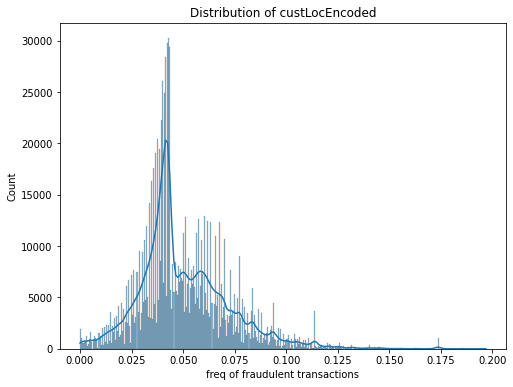

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(train['custLocEncoded'], kde=True)
plt.xlabel('freq of fraudulent transactions')
plt.ylabel('Count')
plt.title('Distribution of custLocEncoded')
plt.show()

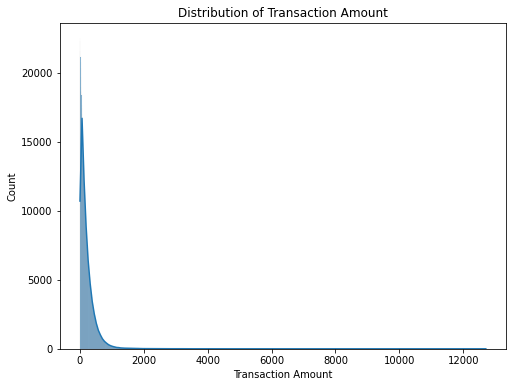

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Transaction Amount'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amount')
plt.show()

Transaction Amount(Rescaled)

In [19]:
scaler = StandardScaler()

# Rescale and fit-transform on training data
train['Transaction Amount Rescaled'] = train['Transaction Amount'].apply(lambda x: math.log10(x))
train['Transaction Amount Rescaled'] = scaler.fit_transform(train[['Transaction Amount Rescaled']])

# Apply log transformation and scale validation data
val['Transaction Amount Rescaled'] = val['Transaction Amount'].apply(lambda x: math.log10(x))
val['Transaction Amount Rescaled'] = scaler.transform(val[['Transaction Amount Rescaled']])

# Apply log transformation and scale test data
test['Transaction Amount Rescaled'] = test['Transaction Amount'].apply(lambda x: math.log10(x))
test['Transaction Amount Rescaled'] = scaler.transform(test[['Transaction Amount Rescaled']])

Price per product

In [22]:
train['Price per product'] = train['Transaction Amount'] / train['Quantity']
val['Price per product'] = val['Transaction Amount'] / val['Quantity']
test['Price per product'] = test['Transaction Amount'] / test['Quantity']

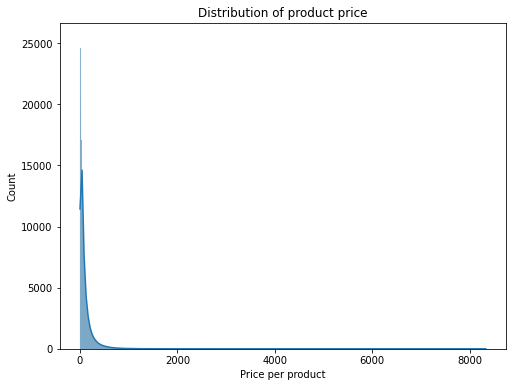

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Price per product'], kde=True)
plt.xlabel('Price per product')
plt.ylabel('Count')
plt.title('Distribution of product price')
plt.show()

Product Price rescaling

In [24]:
scaler = StandardScaler()

# Rescale product price for training set
train['Product Price Rescaled'] = train['Price per product'].apply(lambda x: math.log10(x))
train['Product Price Rescaled'] = scaler.fit_transform(train[['Product Price Rescaled']])  # Fit on training set

# Rescale product price for validation set
val['Product Price Rescaled'] = val['Price per product'].apply(lambda x: math.log10(x))
val['Product Price Rescaled'] = scaler.transform(val[['Product Price Rescaled']])  # Transform using training scaler

# Rescale product price for test set
test['Product Price Rescaled'] = test['Price per product'].apply(lambda x: math.log10(x))
test['Product Price Rescaled'] = scaler.transform(test[['Product Price Rescaled']])  # Transform using training scaler

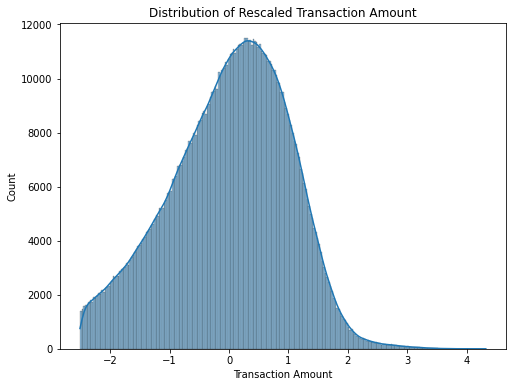

In [25]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Transaction Amount Rescaled'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Rescaled Transaction Amount')
plt.show()

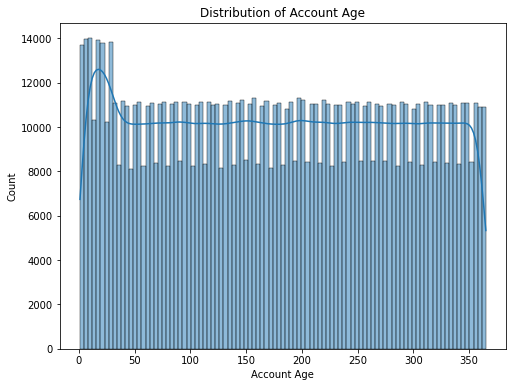

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Account Age Days'], kde=True)
plt.xlabel('Account Age')
plt.ylabel('Count')
plt.title('Distribution of Account Age')
plt.show()

Account age rescaled

In [27]:
scaler = StandardScaler()

train['Account Age Rescaled'] = train['Account Age Days'].apply(lambda x: math.log10(x))
train['Account Age Rescaled'] = scaler.fit_transform(train[['Account Age Rescaled']])  # Fit on training set

val['Account Age Rescaled'] = val['Account Age Days'].apply(lambda x: math.log10(x))
val['Account Age Rescaled'] = scaler.transform(val[['Account Age Rescaled']])  # Transform using training scaler

test['Account Age Rescaled'] = test['Account Age Days'].apply(lambda x: math.log10(x))
test['Account Age Rescaled'] = scaler.transform(test[['Account Age Rescaled']])  # Transform using training scaler

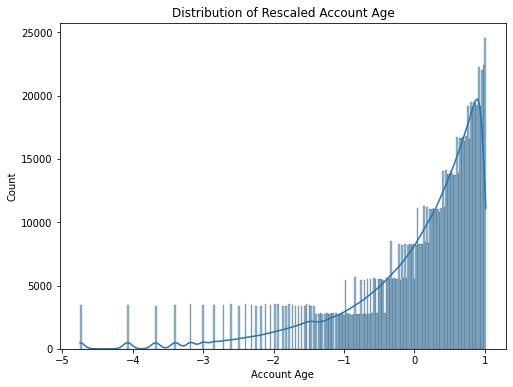

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Account Age Rescaled'], kde=True)
plt.xlabel('Account Age')
plt.ylabel('Count')
plt.title('Distribution of Rescaled Account Age')
plt.show()

In [29]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

features = ['Time of Day', 'Age Group', 'Payment Method', 'Product Category', 'Device Used', 'Transaction Month', 'Transaction Day of Week']


# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training set features
encoder.fit(train[features])

# Transform the training set
encoded_train = pd.DataFrame(
    encoder.transform(train[features]), 
    columns=encoder.get_feature_names_out(features)
)
encoded_train.index = train.index  # Ensure indices align
train = pd.concat([train, encoded_train], axis=1)

# Transform the validation set
encoded_val = pd.DataFrame(
    encoder.transform(val[features]), 
    columns=encoder.get_feature_names_out(features)
)
encoded_val.index = val.index  # Ensure indices align
val = pd.concat([val, encoded_val], axis=1)

# Transform the test set
encoded_test = pd.DataFrame(
    encoder.transform(test[features]), 
    columns=encoder.get_feature_names_out(features)
)
encoded_test.index = test.index  # Ensure indices align
test = pd.concat([test, encoded_test], axis=1)



In [30]:
train.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Hour,Is Fraudulent,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,custLocEncoded,Transaction Amount Rescaled,Price per product,Product Price Rescaled,Account Age Rescaled,Time of Day_0,Time of Day_1,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6
170703,9510fb91-53c5-48cf-8f52-503906400d31,b7cd54bd-55a5-4366-8824-39b96dc93172,148.38,2024-02-17 11:59:17,debit card,toys & games,5,53.0,Port Andrea,tablet,104.74.150.236,"PSC 9232, Box 8361\nAPO AP 83355","PSC 9232, Box 8361\nAPO AP 83355",282,11,0,4,17,5,2,0,1,0.055118,0.068994,29.676000,-0.486905,0.761759,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44874,c2e16192-de80-4eef-8394-0689b5932014,d7c6f09e-2949-454e-9dea-1ff91d147069,120.34,2024-04-02 11:13:02,credit card,health & beauty,1,35.0,Kendraville,mobile,18.102.137.222,76632 Shane Branch Suite 326\nNorth Samuelvill...,76632 Shane Branch Suite 326\nNorth Samuelvill...,347,11,0,2,2,1,4,0,1,0.040213,-0.131101,120.340000,0.687952,0.964402,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1164826,63ec72a7-b836-411b-91a6-b97244fb9863,61cab450-4def-42a0-9190-4b38dcd8b6fc,112.44,2024-02-22 06:52:35,PayPal,clothing,3,32.0,Davistown,mobile,46.127.34.27,"4588 Logan Wall Suite 845\nLake Nicholas, RI 4...","4588 Logan Wall Suite 845\nLake Nicholas, RI 4...",294,6,0,2,22,3,2,0,1,0.056338,-0.195968,37.480000,-0.290980,0.802473,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
130228,88a1cc98-dab6-44e4-a5e6-6e636f5ae44d,cb8c0540-7f02-4d73-9a34-0456194a7e15,66.26,2024-03-31 09:49:44,debit card,electronics,4,38.0,New Matthewchester,tablet,131.13.112.34,"398 Mathis Overpass\nPort Davidburgh, NY 45946","398 Mathis Overpass\nPort Davidburgh, NY 45946",217,9,0,2,31,6,3,0,1,0.101320,-0.701170,16.565000,-0.976195,0.505781,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
857133,4c0d32b1-d218-411b-a4e9-6e70bb17efd3,3f3b7498-a13e-44c6-8685-870974425c49,375.28,2024-03-16 18:14:23,bank transfer,home & garden,3,50.0,East Davidmouth,mobile,136.84.24.53,"460 Rose Cliff\nScottview, SC 89722","460 Rose Cliff\nScottview, SC 89722",167,18,0,4,16,5,3,0,1,0.000608,0.955426,125.093333,0.720461,0.249907,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
X_train = train.drop(columns=[
                    'Transaction ID',
                    'Customer ID',
                    'Transaction Date',
                    'Payment Method',
                    'Product Category',
                    'Customer Location',
                    'Device Used',
                    'Shipping Address',
                    'Billing Address', 
                    'IP Address',
                    'Transaction Amount',
                    'Account Age Days',
                    'Price per product',
                    'Customer Age',
                    'Transaction Hour',                                      
                    'Age Group',
                    'Time of Day',
                    'Transaction Month',
                    'Transaction Day of Week'
                    ])



In [32]:
X_train.head()

,Quantity,Is Fraudulent,Transaction Day,isAddressMatched,custLocEncoded,Transaction Amount Rescaled,Product Price Rescaled,Account Age Rescaled,Time of Day_0,Time of Day_1,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6
170703,5,0,17,1,0.055118,0.068994,-0.486905,0.761759,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44874,1,0,2,1,0.040213,-0.131101,0.687952,0.964402,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1164826,3,0,22,1,0.056338,-0.195968,-0.290980,0.802473,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
130228,4,0,31,1,0.101320,-0.701170,-0.976195,0.505781,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
857133,3,0,16,1,0.000608,0.955426,0.720461,0.249907,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# do the same for val and test
y_train = train['Is Fraudulent']
X_val = val[X_train.columns]
y_val = val['Is Fraudulent']
X_test = test[X_train.columns]
y_test = test['Is Fraudulent']  


## Handling imbalanced data
Observing the ratio of fraudulent to non-fraudulent transactions, there is a huge imbalance (only 5% fraudulent transactions). This could cause problems for some of our models, as they may tend to favor the majority class and result in a poor performance in identifying fraud.

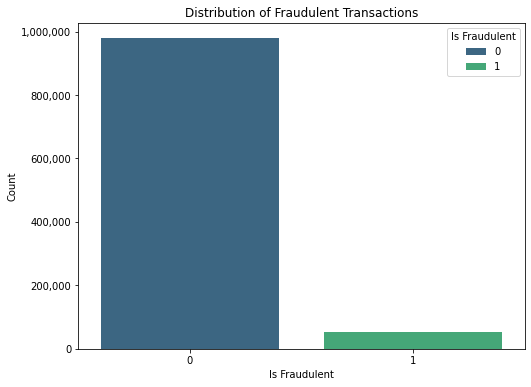

ratio:  Is Fraudulent
0    0.94987
1    0.05013
Name: proportion, dtype: float64


In [37]:
import matplotlib.ticker as mticker

#temporarily add the target column back for visualization
X_train['Is Fraudulent'] = y_train

plt.figure(figsize=(8, 6))
sns.countplot(x='Is Fraudulent', hue='Is Fraudulent', data=X_train, palette='viridis', dodge=False, legend=True)
plt.xlabel('Is Fraudulent')
plt.ylabel('Count')
plt.title('Distribution of Fraudulent Transactions')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

fraud_nonfraud_ratio = X_train['Is Fraudulent'].value_counts(normalize=True)

print("ratio: ",fraud_nonfraud_ratio)

# Drop the target column after plotting to avoid modifying X_train permanently
X_train = X_train.drop(columns=['Is Fraudulent'])
X_val = X_val.drop(columns=['Is Fraudulent'])     
X_test = X_test.drop(columns=['Is Fraudulent'])   


## **Train and test split with oversampling**

In [38]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
print(X_train_oversampled.shape,y_train_oversampled.shape)

(1958758, 38) (1958758,)


## **Random Forest**

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 75, 100],  
    'max_depth': [None, 10, 15],    
    'max_features': ['sqrt'],  
    'bootstrap': [True],
    'min_samples_split': [2, 4, 5], 
    'min_samples_leaf': [1, 2, 3],  
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,       
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Perform RandomizedSearchCV on the oversampled training data
print("Starting hyperparameter tuning...")
random_search.fit(X_train_oversampled, y_train_oversampled)

# Get the best model from the search
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# Predict on validation data
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]  # For AUC score

# Evaluate on validation set
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\nValidation ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # For AUC score





Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    209867
           1       0.39      0.21      0.27     11076

    accuracy                           0.94    220943
   macro avg       0.68      0.60      0.62    220943
weighted avg       0.93      0.94      0.94    220943


Validation Confusion Matrix:
[[206222   3645]
 [  8733   2343]]

Validation ROC AUC Score: 0.7112212478761527


In [45]:
# Evaluate on test set
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nTest ROC AUC Score:", roc_auc_score(y_test, y_test_proba))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    209868
           1       0.39      0.21      0.27     11075

    accuracy                           0.94    220943
   macro avg       0.67      0.60      0.62    220943
weighted avg       0.93      0.94      0.94    220943


Test Confusion Matrix:
[[206110   3758]
 [  8722   2353]]

Test ROC AUC Score: 0.7115686596683086


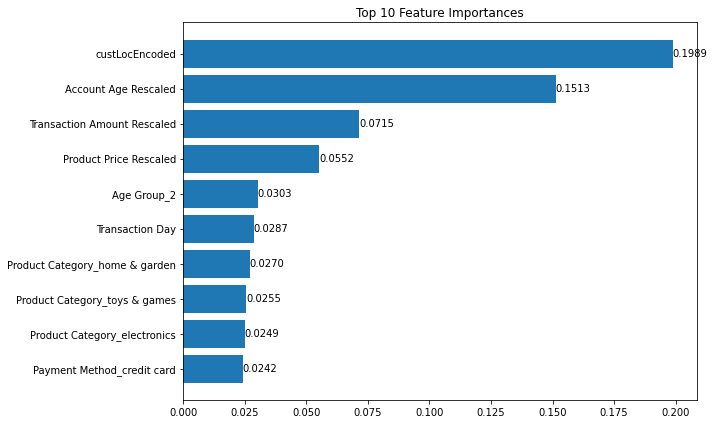

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay


# Define ROC Curve plotting function
def plot_roc_curve(ax, y_true, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()

# Define Precision-Recall Curve plotting function
def plot_precision_recall_curve(ax, y_true, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend()




# Extract feature importance from the model
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort indices by importance
feature_names = X_train.columns

# Get the top 10 features
top_features = [(feature_names[i], feature_importance[i]) for i in sorted_idx[:10]]

# Plotting feature importance
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for feature importance
ax.barh(
    [name for name, _ in top_features],
    [score for _, score in top_features]
)
ax.set_title("Top 10 Feature Importances")
ax.invert_yaxis()  # To have the highest importance on top

# Annotate bars with feature importance scores
for i, (name, score) in enumerate(top_features):
    ax.text(score, i, f"{score:.4f}", va='center')

plt.tight_layout()
plt.show()



Validation Set

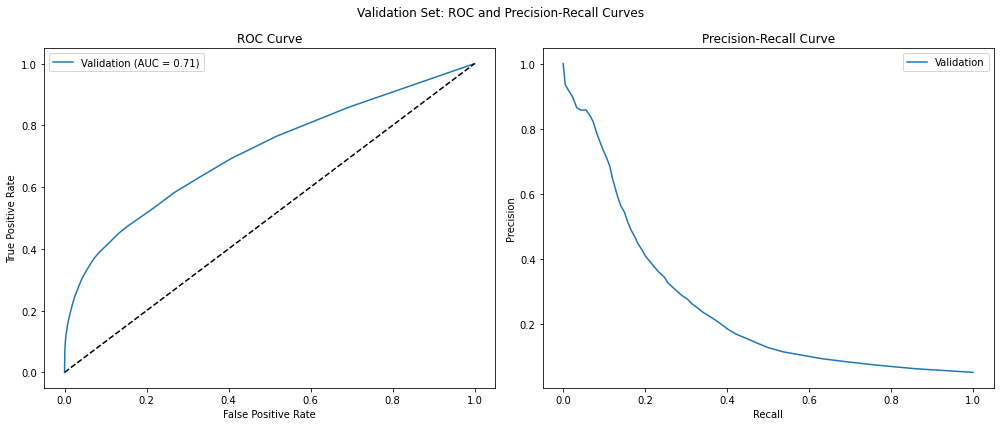

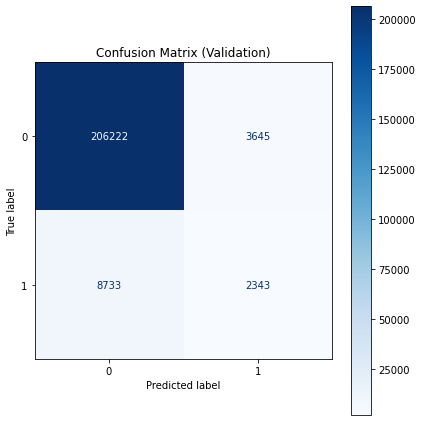

In [57]:
# Plot ROC and Precision-Recall Curves for Validation Set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve for Validation Set
plot_roc_curve(axes[0], y_val, y_val_proba, "Validation")

# Precision-Recall Curve for Validation Set
plot_precision_recall_curve(axes[1], y_val, y_val_proba, "Validation")

plt.suptitle("Validation Set: ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Validation Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val, best_model.predict(X_val), ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


Test Set

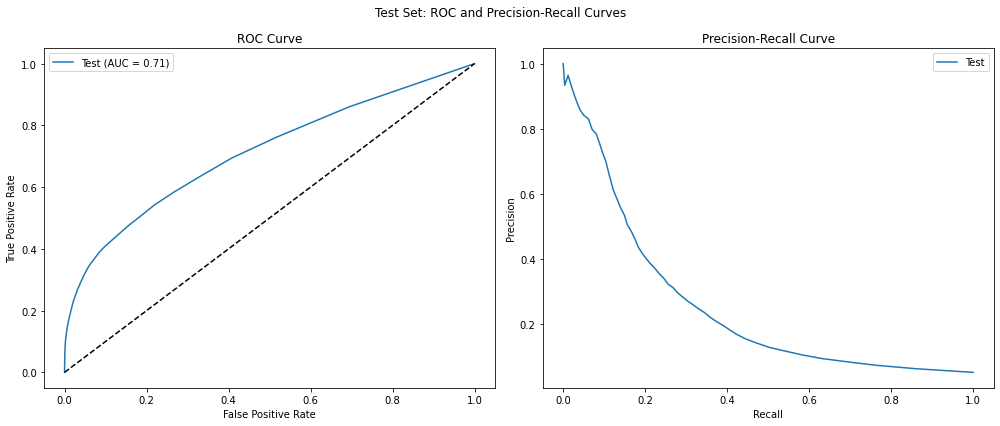

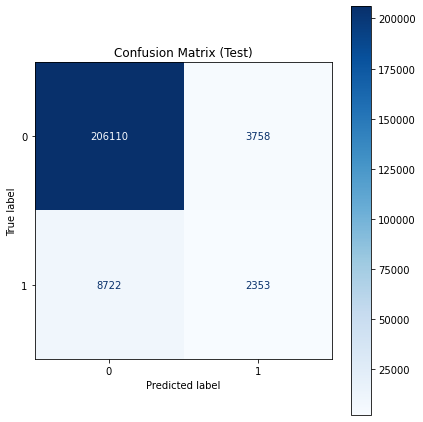

In [58]:
# Plot ROC and Precision-Recall Curves for Test Set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve for Test Set
plot_roc_curve(axes[0], y_test, y_test_proba, "Test")

# Precision-Recall Curve for Test Set
plot_precision_recall_curve(axes[1], y_test, y_test_proba, "Test")

plt.suptitle("Test Set: ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Test Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test), ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()
